# Principle Component Analysis and Latent Semantic Indexing

Lab Objective: Understand the basics of principle component analysis and latent semantic indexing. The lab details are found at http://www.acme.byu.edu/wp-content/uploads/2018/02/PCA_LSI.pdf.

In [1]:
import os
import string
import numpy as np
from math import log
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla

%matplotlib inline
plt.rcParams["figure.dpi"] = 300

## Problem 1

Recreate Figure 18.4 by performing PCA on the iris dataset, keeping the first two principal components.

In [3]:
iris = datasets.load_iris()
X = iris.data
Y = X - X.mean(axis=0)
#svd
U,S,VT = la.svd(Y, full_matrices=False)
S**2/(S**2).sum() # variance percentages

array([ 0.92461621,  0.05301557,  0.01718514,  0.00518309])

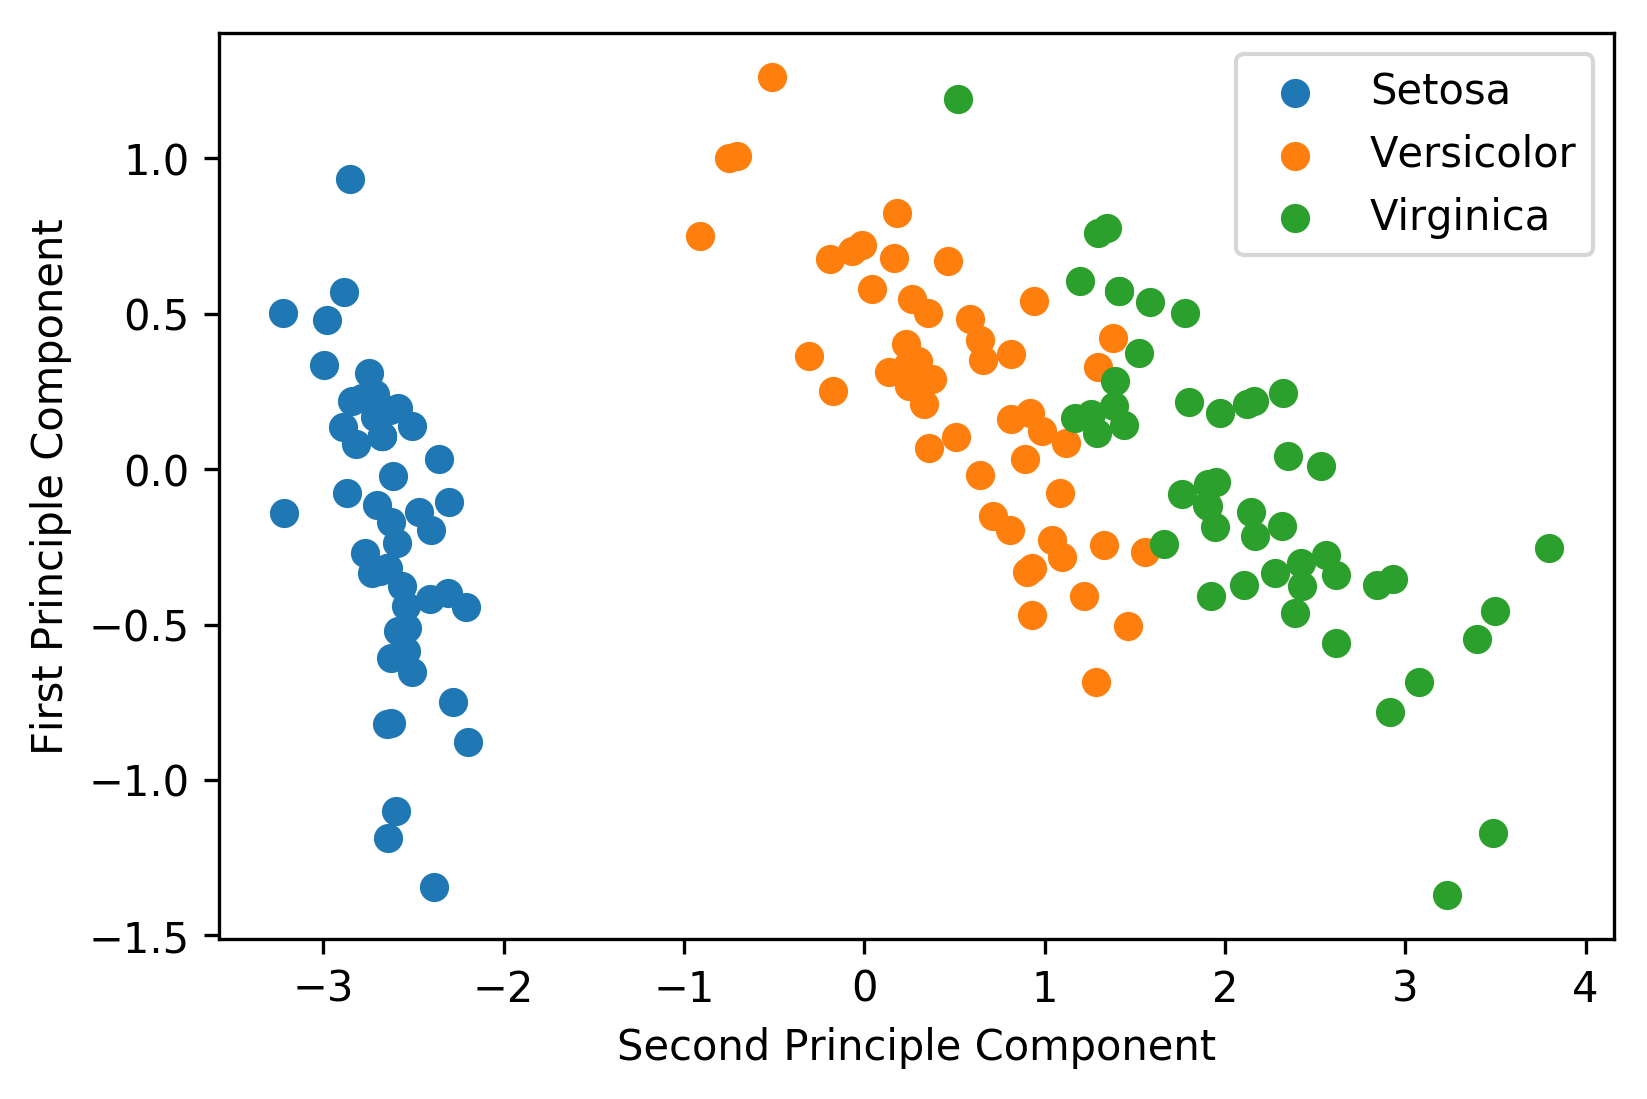

In [4]:
VT2 = VT.T[:, :2]
Yhat = Y.dot(VT2)
labels = ["Setosa", "Versicolor",  "Virginica"]
for i in range(3):
    plt.scatter(Yhat[iris.target==i][:, 0], Yhat[iris.target==i][:, 1], label = labels[i])
plt.xlabel("Second Principle Component")
plt.ylabel("First Principle Component")
plt.legend()
plt.show()

## Problem 2

Using the techniques of LSI, applied to the word count matrix $X$, and keeping the first 7 principal components, find the most similar and least similar speeches to both Bill Clinton's 1993 speech and to Ronald Reagan's 1984 speech.

In [5]:
# Get list of filepaths to each text file in the folder.
folder = "./Addresses/"
paths = [folder+p for p in os.listdir(folder) if p[-4:]==".txt"]

# Helper function to get list of words in a string.
def extractWords(text):
    ignore = string.punctuation + string.digits
    cleaned = "".join([t for t in text.strip() if t not in ignore])
    return cleaned.lower().split()

# Initialize vocab set, then read each file and add to the vocab set.
vocab = set()
for p in paths:
    with open(p, 'r') as infile:
        for line in infile:
            vocab.update(extractWords(line))

In [6]:
# load stopwords
with open("stopwords.txt", 'r') as f:
    stops = set([w.strip().lower() for w in f.readlines()])

# remove stopwords from vocabulary, create ordering
vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

In [7]:
counts = []      # holds the entries of X
doc_index = []   # holds the row index of X
word_index = []  # holds the column index of X
t = np.zeros(len(vocab))

# Iterate through the documents.
for doc, p in enumerate(paths):
    with open(p, 'r') as f:
        # Create the word counter.
        ctr = Counter()
        for line in f:
            ctr.update(extractWords(line))
        # Iterate through the word counter, store counts.
        for word, count in ctr.items():
            if word in vocab:
                word_index.append(vocab[word])
                counts.append(count)
                doc_index.append(doc)
                t[word_index] += count

# Create sparse matrix holding these word counts.
X = sparse.csr_matrix((counts, [doc_index, word_index]),
                       shape=(len(paths), len(vocab)), dtype=np.float)

In [8]:
U,S,VT = sparse.linalg.svds(X, k=7)
Xhat = X.dot(VT.T)

def find_most_similar(X, Xhat, i):
    """X: A matrix holding the word count for each document
    i: the ith document
    Finds the most similar document acording to algorithm given in the lab."""
    angles = []
    X_i = Xhat[i,:] 
    xi_norm = la.norm(X_i)
    for j in range(X.shape[0]):
        num = np.inner(X_i, Xhat[j,:])
        den = xi_norm*la.norm(Xhat[j,:])
        angles.append(num/den)   
    return np.argsort(np.array(angles))[-2], np.argsort(np.array(angles))[0]

In [9]:
reagan = paths.index('./Addresses/1984-Reagan.txt')
clinton = paths.index('./Addresses/1993-Clinton.txt')

In [10]:
# Most similar document to Reagan 1984
r_most_similar, r_least_similar = find_most_similar(X, Xhat, reagan)
c_most_similar, c_least_similar = find_most_similar(X, Xhat, clinton)
print("The most similar document to Reagan1984 is", paths[r_most_similar], "The least similar is", paths[r_least_similar])
print("The most similar document to Clinton1993 is", paths[c_most_similar], "The least similar is",paths[c_least_similar])

The most similar document to Reagan1984 is ./Addresses/1988-Reagan.txt The least similar is ./Addresses/1946-Truman.txt
The most similar document to Clinton1993 is ./Addresses/2010-Obama.txt The least similar is ./Addresses/1951-Truman.txt


## Problem 3

Repeat Problem 2 using the matrix $A$.
Do your answers seem more reasonable than before?

In [11]:
t = np.zeros(len(vocab))
counts = []
doc_index = []
word_index = []

# get doc-term counts and global term counts
for doc, path in enumerate(paths):
    with open(path, 'r') as f:
        # create the word counter
        ctr = Counter()
        for line in f:
            words = extractWords(line)
            ctr.update(words)
        # iterate through the word counter, store counts
        for word, count in ctr.items():
            if word in vocab:
                word_ind = vocab[word]
                word_index.append(word_ind)
                counts.append(count)
                doc_index.append(doc)
                t[word_ind] += count

# Get global weights.
g = np.ones(len(vocab))
logM = log(len(paths))
for count, word in zip(counts, word_index):
    p = count/float(t[word])
    g[word] += p*log(p+1)/logM

# Get globally weighted counts.
gwcounts = []
for count, word in zip(counts, word_index):
    gwcounts.append(g[word]*log(count+1))

# Create sparse matrix holding these globally weighted word counts
A = sparse.csr_matrix((gwcounts, [doc_index,word_index]),
                      shape=(len(paths), len(vocab)), dtype=np.float)


In [12]:
U,S,VT = sparse.linalg.svds(A, k=7)
Ahat = A.dot(VT.T)

# Most similar document to Reagan 1984
r_most_similar, r_least_similar = find_most_similar(A, Ahat, reagan)
c_most_similar, c_least_similar = find_most_similar(A, Ahat, clinton)
print("The most similar document to Reagan1984 is", paths[r_most_similar], ". The least similar is", paths[r_least_similar])
print("The most similar document to Clinton1993 is", paths[c_most_similar], ". The least similar is", paths[c_least_similar])

The most similar document to Reagan1984 is ./Addresses/1985-Reagan.txt . The least similar is ./Addresses/1946-Truman.txt
The most similar document to Clinton1993 is ./Addresses/1992-Bush.txt . The least similar is ./Addresses/1946-Truman.txt
